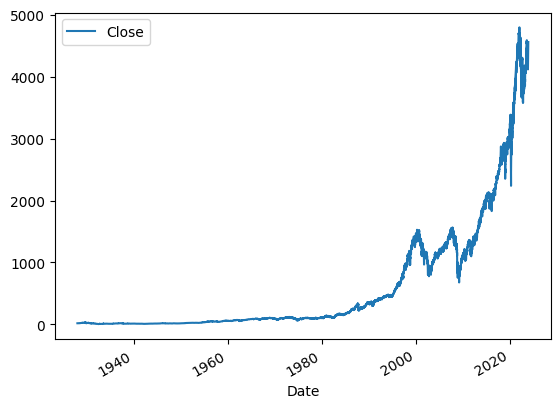

In [24]:
# Importing necessary libraries
import yfinance as yf
import matplotlib.pyplot as plt

# Fetching the historical data for S&P 500 using yfinance
sp500 = yf.Ticker("^GSPC")  
sp500 = sp500.history(period="max")  

# Plotting the closing prices over time
sp500.plot.line(y="Close", use_index=True) 

# Removing unnecessary columns from the dataframe
del sp500["Dividends"]  
del sp500["Stock Splits"]  

# Creating a new column to store the next day's closing price
sp500["Tomorrow"] = sp500["Close"].shift(-1)  




In [25]:
# Creating a target variable for prediction
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
# 'Target' column will be 1 if tomorrow's close is greater than today's, else 0

print(sp500)

                                  Open         High          Low        Close  \
Date                                                                            
1927-12-30 00:00:00-05:00    17.660000    17.660000    17.660000    17.660000   
1928-01-03 00:00:00-05:00    17.760000    17.760000    17.760000    17.760000   
1928-01-04 00:00:00-05:00    17.719999    17.719999    17.719999    17.719999   
1928-01-05 00:00:00-05:00    17.549999    17.549999    17.549999    17.549999   
1928-01-06 00:00:00-05:00    17.660000    17.660000    17.660000    17.660000   
...                                ...          ...          ...          ...   
2023-11-17 00:00:00-05:00  4509.549805  4520.120117  4499.660156  4514.020020   
2023-11-20 00:00:00-05:00  4511.700195  4557.109863  4510.359863  4547.379883   
2023-11-21 00:00:00-05:00  4538.770020  4542.140137  4525.509766  4538.189941   
2023-11-22 00:00:00-05:00  4553.040039  4568.430176  4545.049805  4556.620117   
2023-11-24 00:00:00-05:00  4

In [26]:
# Trimming the dataset to start from 1st January 1990
sp500 = sp500.loc["1990-01-01":].copy()  

# Importing RandomForestClassifier from scikit-learn
from sklearn.ensemble import RandomForestClassifier

# Creating a RandomForestClassifier model with specified parameters
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

# Splitting the dataset into training and testing sets
train = sp500.iloc[:-100]  
test = sp500.iloc[-100:]   

# Selecting predictors for the model
predictors = ["Close", "Volume", "Open", "High", "Low"]

# Training the model on the training data
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

<Axes: xlabel='Date'>

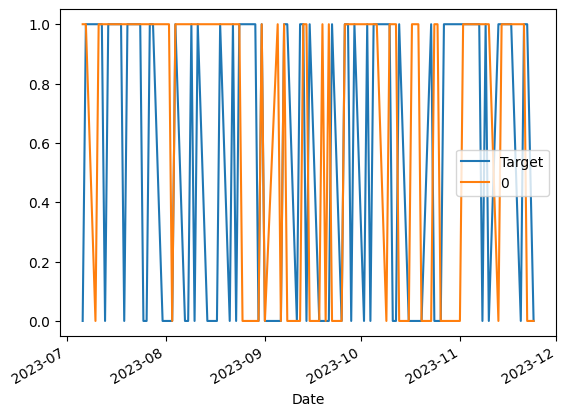

In [27]:
# Importing precision_score from sklearn for model evaluation
from sklearn.metrics import precision_score

# Generating predictions for the test set
preds = model.predict(test[predictors])

# Converting predictions to a pandas Series and aligning with the test index
import pandas as pd
preds = pd.Series(preds, index=test.index)

# Calculating the precision score of the model
precision_score(test["Target"], preds)

# Combining the actual targets and predictions into a single dataframe
combined = pd.concat([test["Target"], preds], axis=1)

# Plotting the actual targets vs predictions for visual evaluation
combined.plot()


In [15]:
# Defining a function to perform model predictions
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])  # Training the model
    preds = model.predict(test[predictors])        # Making predictions on the test set
    preds = pd.Series(preds, index=test.index, name="Predictions")  # Formatting predictions
    combined = pd.concat([test["Target"], preds], axis=1)  # Combining actual and predicted values
    return combined

# Defining a backtesting function to evaluate the model over time
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    # Iteratively testing the model on different time segments of data
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()  # Creating a training set
        test = data.iloc[i:i+step].copy()  # Creating a test set
        predictions = predict(train, test, predictors, model)  # Getting predictions
        all_predictions.append(predictions)
    return pd.concat(all_predictions)  # Combining all predictions

# Running the backtest on the S&P 500 data
predictions = backtest(sp500, model, predictors)

# Displaying the distribution of predictions
predictions["Predictions"].value_counts()


Predictions
0    3452
1    2589
Name: count, dtype: int64

In [28]:
# Evaluating the overall precision of the backtested predictions
precision_score(predictions["Target"], predictions["Predictions"])

# Calculating the proportion of each class in the target variable
predictions["Target"].value_counts() / predictions.shape[0]


Target
1    0.543741
0    0.456259
Name: count, dtype: float64

In [29]:
# Defining different time horizons to create new features
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

# Loop to create new features based on rolling averages and trends
for horizon in horizons:
    # Calculating rolling averages for the specified horizon
    rolling_averages = sp500.rolling(horizon).mean()

    # Creating a new feature: ratio of current close price to rolling average
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    # Creating a new feature: trend based on sum of past 'Target' values over the horizon
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    # Adding new features to the list of predictors
    new_predictors += [ratio_column, trend_column]

# Removing rows with NaN values in any column except 'Tomorrow'
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

# Displaying the modified DataFrame
print(sp500)

                                  Open         High          Low        Close  \
Date                                                                            
1993-12-14 00:00:00-05:00   465.730011   466.119995   462.459991   463.059998   
1993-12-15 00:00:00-05:00   463.059998   463.690002   461.839996   461.839996   
1993-12-16 00:00:00-05:00   461.859985   463.980011   461.859985   463.339996   
1993-12-17 00:00:00-05:00   463.339996   466.380005   463.339996   466.380005   
1993-12-20 00:00:00-05:00   466.380005   466.899994   465.529999   465.850006   
...                                ...          ...          ...          ...   
2023-11-17 00:00:00-05:00  4509.549805  4520.120117  4499.660156  4514.020020   
2023-11-20 00:00:00-05:00  4511.700195  4557.109863  4510.359863  4547.379883   
2023-11-21 00:00:00-05:00  4538.770020  4542.140137  4525.509766  4538.189941   
2023-11-22 00:00:00-05:00  4553.040039  4568.430176  4545.049805  4556.620117   
2023-11-24 00:00:00-05:00  4

In [30]:
# Initializing an updated RandomForestClassifier model with new parameters
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

# Defining a function for model prediction with a custom threshold
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])  # Training the model with the training data
    preds = model.predict_proba(test[predictors])[:, 1]  # Predicting probabilities for class '1'
    
    # Applying a custom threshold to determine final predictions
    preds[preds >= .6] = 1  # Classifying as '1' if probability is 0.6 or higher
    preds[preds < .6] = 0   # Classifying as '0' if probability is below 0.6
    preds = pd.Series(preds, index=test.index, name="Predictions")  # Creating a Series for predictions
    
    combined = pd.concat([test["Target"], preds], axis=1)  # Combining actual and predicted values
    return combined

# Running the backtest on the updated model and new predictors
predictions = backtest(sp500, model, new_predictors)

# Displaying the distribution of model predictions
predictions["Predictions"].value_counts()

# Evaluating the precision of the updated model's predictions
precision_score(predictions["Target"], predictions["Predictions"])


0.5714285714285714

In [31]:
# Calculating and displaying the proportion of each class in the target variable
predictions["Target"].value_counts() / predictions.shape[0]

# Printing the predictions DataFrame for review
print(predictions)

                           Target  Predictions
Date                                          
2003-11-14 00:00:00-05:00       0          0.0
2003-11-17 00:00:00-05:00       0          1.0
2003-11-18 00:00:00-05:00       1          1.0
2003-11-19 00:00:00-05:00       0          0.0
2003-11-20 00:00:00-05:00       1          1.0
...                           ...          ...
2023-11-17 00:00:00-05:00       1          0.0
2023-11-20 00:00:00-05:00       0          0.0
2023-11-21 00:00:00-05:00       1          0.0
2023-11-22 00:00:00-05:00       1          0.0
2023-11-24 00:00:00-05:00       0          0.0

[5041 rows x 2 columns]
